In [ ]:
import requests
import json
import csv
import matplotlib.pyplot as plt
from collections import Counter
import logging
import pandas as pd
from bg_context import generate_pl_bg, generate_ev_bg, generate_na_bg, bg_monitoring, bg_evaluating, bg_planning
from ollama_class import OllamaLLM

In [23]:
def save_to_csv(data, filename):
    """
    Save generated data to a CSV file.

    Args:
        data (list): List of dictionaries containing generated texts, scores, and tags.
        filename (str): Path to the output CSV file.
    """
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

def save_to_json(data, filename):
    """
    Save generated data to a JSON file.

    Args:
        data (list): List of dictionaries containing generated texts, scores, and tags.
        filename (str): Path to the output JSON file.
    """
    with open(filename, "w") as f:
        json.dump(data, f, indent=4)
    print(f"Data saved to {filename}")

In [38]:
# Configure logging
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')

In [27]:
ollama = OllamaLLM(api_url="http://localhost:11434/api/generate")

# Generate dataset on Planning and Evaluating

In [36]:
# Generate data in batches
generated_data = ollama.generate_na_data("llama3.2", 20)
# Save to CSV
save_to_csv(generated_data, "output_classification_generated_na.csv")
print(f"{len(generated_data)} examples saved")

Error generating batch 1: string indices must be integers
Error generating batch 2: string indices must be integers
Data saved to output_classification_generated_na.csv
0 examples saved


# Read real-world dataset on monitoring

In [73]:
# Replace with actual file path
input_file = 'reflections.csv'
# input_file = 'reflections_test.csv' 

rows = []
output_rows = []

# Read the input CSV
try:
    with open(input_file, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')  # Adjust delimiter if necessary
        for row in reader:
            rows.append(row)
except Exception as e:
    logging.error(f"Error reading input file: {e}")
    exit(1)

## Enhance real-world dataset on monitoring

In [75]:
output_file_enhance = 'enhanced_responses_with_context.csv'

output_rows_enhance = []

for row in rows:
    try:
        text = row[2]
        enhanced_text_ctx = ollama.minimally_enhance_text("llama3.2", text, bg_monitoring)
        enhanced_text = enhanced_text_ctx.get("enhanced_text", "")
        output_rows_enhance.append([row[0], row[1], text, enhanced_text])
    except Exception as e:
        logging.error(f"Error enhancing text for row {row}: {e}")
        output_rows_enhance.append([row[0], row[1], text, "Error enhancing text"])

try:
    with open(output_file_enhance, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["ID", "Code", "Original Text", "Enhanced Text"])
        writer.writerows(output_rows_enhance)
    print(f"Minimally enhanced responses saved to {output_file_enhance}")
except Exception as e:
    logging.error(f"Error writing to output file: {e}")

Minimally enhanced responses saved to enhanced_responses_with_context.csv


Extract text and tag only for better sub-processing

In [ ]:
output_classification = [[row[3], "monitor"] for row in output_rows_enhance]

with open("output_classification_monitoring.csv", 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["text", "tag"])
    writer.writerows(output_classification)

# Metacognition level grading

In [ ]:
# Perform analysis
output_rows = []

for row in rows:
    try:
        text = row[2]  # Assuming the third column contains the text

        # Without context
        try:
            monitoring_result = ollama.analyze_monitoring("llama3.2", text)
            monitoring_score = monitoring_result.get("monitoring_score", 0)
        except Exception as e:
            logging.error(f"Error in monitoring analysis without context for text '{text}': {e}")
            monitoring_score = 0

        # With context
        try:
            bg_monitoring = "Background information for monitoring analysis."  # Replace with actual context
            monitoring_result_ctx = ollama.analyze_monitoring("llama3.2", text, context=bg_monitoring)
            monitoring_score_ctx = monitoring_result_ctx.get("monitoring_score", 0)
        except Exception as e:
            logging.error(f"Error in monitoring analysis with context for text '{text}': {e}")
            monitoring_score_ctx = 0

        # Combine results
        output_rows.append([
            row[0], row[1], text,  # Original data
            monitoring_score, monitoring_score_ctx
        ])

    except Exception as e:
        logging.error(f"Error processing row {row}: {e}")
        # Append row with default values for scores
        output_rows.append([
            row[0], row[1], row[2] if len(row) > 2 else "",  # Handle missing or malformed rows
            0, 0  # Default scores for monitoring
        ])

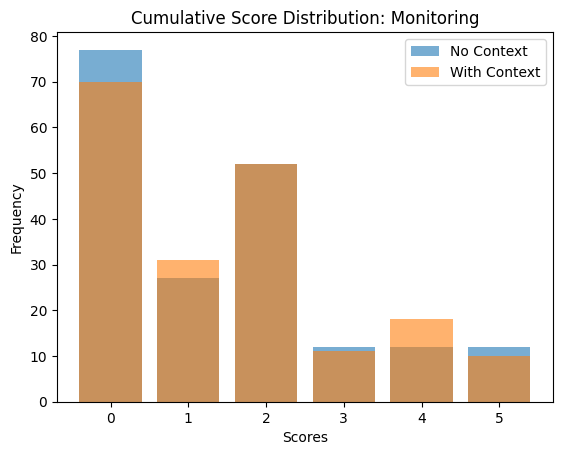

Monitoring analysis complete. Results saved to output CSV and plot generated.


In [ ]:
output_file = 'monitoring_output.csv'

# Write results to new CSV
with open(output_file, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([
        "ID", "Code", "Text", "Monitoring (No Context)", "Monitoring (With Context)"
    ])
    writer.writerows(output_rows)

# Prepare data for cumulative bar chart
no_context_scores = Counter(row[3] for row in output_rows)  # Monitoring (No Context)
with_context_scores = Counter(row[4] for row in output_rows)  # Monitoring (With Context)

# Plot cumulative bar charts
x_labels = sorted(set(no_context_scores.keys()).union(with_context_scores.keys()))
no_context_values = [no_context_scores.get(x, 0) for x in x_labels]
with_context_values = [with_context_scores.get(x, 0) for x in x_labels]

plt.bar(x_labels, no_context_values, alpha=0.6, label="No Context")
plt.bar(x_labels, with_context_values, alpha=0.6, label="With Context")
plt.xlabel("Scores")
plt.ylabel("Frequency")
plt.title("Cumulative Score Distribution: Monitoring")
plt.legend()
plt.savefig('monitoring_score_distribution.png')
plt.show()

print("Monitoring analysis complete. Results saved to output CSV and plot generated.")


# Common Methods to Measure Metacognition

## 1. Self-Report Questionnaires
- **Description:** Assess individuals' metacognitive knowledge and regulation through structured surveys.
- **Examples:**
  - **Metacognitive Awareness Inventory (MAI):** Measures metacognitive knowledge and regulation across domains.
  - **State Metacognitive Inventory (SMI):** Focuses on task-specific metacognitive states.
  - **Metacognitive Activities Inventory (MCAI):** Used in educational settings to understand students' metacognitive strategies.
- **Strengths:** Easy to administer; allows self-reflection.
- **Limitations:** Subject to biases such as overestimation or social desirability effects.
- **Reference:** Schraw, G., & Dennison, R. S. (1994). *Assessing metacognitive awareness.*

---

## 2. Think-Aloud Protocols
- **Description:** Participants verbalize their thought processes while performing a task, providing real-time insights into planning, monitoring, and evaluation.
- **Strengths:** Captures dynamic metacognitive processes.
- **Limitations:** Time-consuming and requires detailed analysis.
- **Reference:** Ericsson, K. A., & Simon, H. A. (1980). *Verbal reports as data.*

---

## 3. Behavioral Observation
- **Description:** Observes actions during problem-solving tasks to infer metacognitive behaviors (e.g., checking work, adjusting strategies).
- **Strengths:** Offers objective insights into behavior.
- **Limitations:** May miss internal metacognitive processes.
- **Reference:** Veenman, M. V. J., & Beishuizen, J. J. (2004). *Evaluating the use of metacognitive skills.*

---

## 4. Task-Specific Assessments
- **Description:** Tasks explicitly designed to elicit metacognitive behaviors.
  - **Judgment of Learning (JOL):** Participants predict how well they will remember or understand material.
  - **Confidence Ratings:** Participants rate their confidence in answers or task performance.
- **Strengths:** Focused and task-oriented.
- **Limitations:** Performance may depend on the task's design.
- **Reference:** Nelson, T. O., & Narens, L. (1990). *Metamemory: A theoretical framework and new findings.*

---

## 5. Post-Task Reflection
- **Description:** Participants analyze and reflect on their task performance, identifying areas for improvement and strategies used.
- **Strengths:** Provides insights into reflective metacognition.
- **Reference:** Zimmerman, B. J. (2002). *Becoming a self-regulated learner.*

---

## 6. Learning Analytics
- **Description:** Analyzes data from online learning platforms (e.g., click patterns, task revisits, resource usage) to infer metacognitive behaviors.
- **Strengths:** Scalable and unobtrusive.
- **Limitations:** Requires advanced data processing techniques.
- **Reference:** Winne, P. H., & Hadwin, A. F. (1998). *Studying as self-regulated learning.*

---

## 7. Physiological Measures
- **Description:** Measures physiological responses during tasks, such as:
  - **Eye Tracking:** Captures gaze patterns to infer attention and strategy use.
  - **EEG/fMRI:** Tracks brain activity in regions associated with metacognition, such as the prefrontal cortex.
- **Strengths:** Provides objective, real-time data.
- **Limitations:** Expensive and may not capture all metacognitive processes.
- **Reference:** Fleming, S. M., & Dolan, R. J. (2012). *The neural basis of metacognitive capacity.*

---

## 8. Experiment-Based Methods
- **Description:** Controlled experiments designed to measure specific metacognitive components, such as:
  - **Error Detection Tasks:** Identify participants' ability to spot and correct errors.
  - **Decision-Making Simulations:** Evaluate planning, monitoring, and strategy adaptation under constraints.
- **Reference:** Koriat, A. (2007). *Metacognition and consciousness.*

---

# References
1. Schraw, G., & Dennison, R. S. (1994). Assessing metacognitive awareness. *Contemporary Educational Psychology*, 19(4), 460–475.
2. Ericsson, K. A., & Simon, H. A. (1980). Verbal reports as data. *Psychological Review*, 87(3), 215–251.
3. Nelson, T. O., & Narens, L. (1990). Metamemory: A theoretical framework and new findings. *The Psychology of Learning and Motivation*, 26, 125–173.
4. Veenman, M. V. J., & Beishuizen, J. J. (2004). Evaluating the use of metacognitive skills. *Learning and Instruction*, 14(2), 89–109.
5. Winne, P. H., & Hadwin, A. F. (1998). Studying as self-regulated learning. *Metacognition in Educational Theory and Practice*, 277–304.
6. Zimmerman, B. J. (2002). Becoming a self-regulated learner: An overview. *Theory into Practice*, 41(2), 64–70.
7. Fleming, S. M., & Dolan, R. J. (2012). The neural basis of metacognitive capacity. *Nature Reviews Neuroscience*, 13(1), 7–21.
8. Koriat, A. (2007). Metacognition and consciousness. *The Cambridge Handbook of Consciousness*, 289–325.


Reliable, rapid, and remote measurement of metacognitive bias
Authors: Not specified
Published: 2024
Summary: 该研究评估了Meta Mind的心理测量特性，包括其在远程环境下快速可靠地测量元认知偏差的能力。 
NATURE

Common computations for metacognition and meta-metacognition
Authors: Not specified
Published: 2023
Summary: 本文探讨了感知决策中元认知和元-元认知之间的共同计算过程，提出了单一系统可以递归地生成二阶和三阶评估。 
OXFORD ACADEMIC

Measuring Metacognitive Knowledge, Monitoring, and Control in the Classroom
Authors: Not specified
Published: 2023
Summary: 本文为在真实环境中测量元认知提供了用户指南，旨在帮助教育者和研究人员探索学生的元认知，以改善他们的元认知过程和成就。 
AJPE

Psychometric properties of the Metacognitive Awareness Inventory (MAI): standardization to an international Spanish with 12 countries
Authors: Not specified
Published: 2024
Summary: 该研究验证了MAI在12个西班牙语国家的标准化版本，结果支持了原始的双因素结构，表明该版本是测量西班牙语国家元认知意识的有效工具。 
SPRINGERLINK

The many facets of metacognition: comparing multiple measures of metacognition in healthy individuals
Authors: Not specified
Published: 2023
Summary: 该研究探讨了元认知的多维概念，比较了健康个体中元认知的多种测量方法，发现在线测量之间存在关联，但与离线测量的关联较少。

Zulkiply, N.
Metacognition and its Relationship with Students' Academic Performance.
Download Link

Rivero Galeano, R., et al.
Metacognitive Strategies and Learning Quality: A Systematic Mapping Study.
Download Link

Anonymous.
Metacognitive Awareness of High School Students.
Download Link

Kumari, S.
Metacognition in Practice: Teaching Students to Think About Their Thinking.
Download Link

Anonymous.
The Impact of Metacognitive Awareness on Academic Success.
Download Link

Anonymous.
Metacognition: An Overview.
Download Link

Anonymous.
Promoting Metacognition to Support Student Learning and Performance.
Download Link

Anonymous.
Turning Abstraction into Concrete: The Role of Metacognition in Teaching and Learning.
Download Link

Anonymous.
Learning Strategies as Metacognitive Factors: A Critical Review.
Download Link

Anonymous.
Metacognition: A Literature Review Research Report.
Download Link